In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os, os.path
from os import walk
import random
from shutil import copyfile
import numpy as np
import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

## Preparing the Data

In [4]:


!pip install kaggle
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats
!unzip dogs-vs-cats.zip
!unzip train.zip

#create the directories for the training, validation, and testing for cats and dogs
!mkdir -p train/training/cats
!mkdir -p train/training/dogs
!mkdir -p train/validation/cats
!mkdir -p train/validation/dogs
!mkdir -p train/testing/cats
!mkdir -p train/testing/dogs

#make directories that will include all cats and dogs, this will help with splitting the data later on
!mkdir -p train/cats
!mkdir -p train/dogs

#move cats and dogs to their respective directories
!mv train/cat.* train/cats
!mv train/dog.* train/dogs

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

In [5]:
#Here the data is split into training, validation, and testing. We only use the training folder because the
#Testing data is not labeled. The split is 0.9(training)/0.05(validation)/0.05(testing).

def split_data(original, train, validation, testing, split):
    files = []

    #Adding file names to a list.
    filenames = next(walk(original), (None, None, []))[2]
    for filename in filenames:
      file = original + filename
      if os.path.getsize(file) > 0:
        files.append(filename)
      else:
        print(filename + " Directory is empty, data was not split")
    #splitting the files and dividing them according to the afforementioned split.
    training_length = int(len(files) * split)
    validation_length = (int(len(files) - training_length))/2
    testing_length = validation_length
    shuffled_set = random.sample(files, len(files))
    training_set=shuffled_set[0:training_length]
    valid_set_idx = int(((len(shuffled_set)-training_length)/2)+training_length)
    validation_set=shuffled_set[training_length:valid_set_idx]
    testing_set=shuffled_set[valid_set_idx:]

    for filename in training_set:
        this_file = original + filename
        destination = train + filename
        copyfile(this_file, destination)

    for filename in validation_set:
        this_file = original + filename
        destination = validation + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = original + filename
        destination = testing + filename
        copyfile(this_file, destination)

#calling the function for both the cats and dogs folders.
split_data("train/cats/", "train/training/cats/","train/validation/cats/" ,"train/testing/cats/", 0.9)
split_data("train/dogs/", "train/training/dogs/","train/validation/dogs/" ,"train/testing/dogs/", 0.9)

## Defining and training the network

In [6]:

#Since convolutional networks are useful when it comes to image classification problems, I decided to go with one.
#We first start by augmenting the training data as when the fitting was done without it the model was heavily
#overfit.The summary for the model is displayed below.
im_w,im_h = 200,200
channels = 3
train_path = 'train/training'
valid_path = 'train/validation'
test_path = 'train/testing'
batch_size = 32
training_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)
validation_datagen =ImageDataGenerator(rescale = 1./255)
testing_datagen =ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(train_path, target_size=(im_h, im_w),
                                                    batch_size=batch_size, class_mode='categorical')

val_generator = validation_datagen.flow_from_directory(valid_path, target_size=(im_h, im_w),
                                                batch_size=batch_size,class_mode='categorical')
test_generator = testing_datagen.flow_from_directory(test_path, target_size=(im_h, im_w),
                                                batch_size=batch_size,class_mode='categorical')
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation='relu', input_shape=(im_w, im_h, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')

])
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Found 22500 images belonging to 2 classes.
Found 1250 images belonging to 2 classes.
Found 1250 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856 

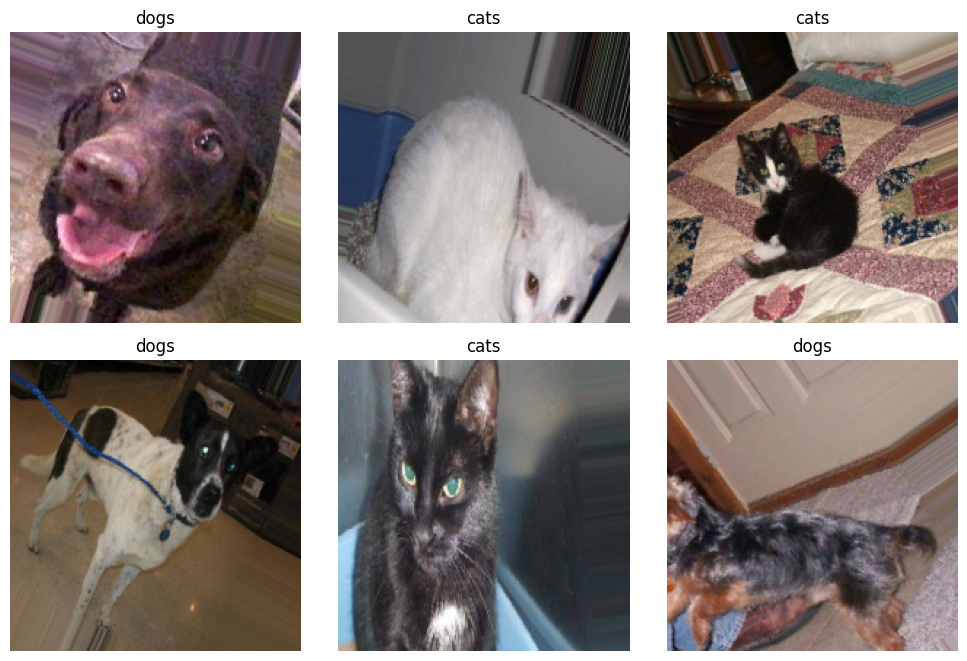

In [7]:
#Displaying some of the images and their labels from the training generator, the images are augmented as mentioned before.
batch = train_generator.next()
images = batch[0]
labels = batch[1]
class_labels = list(train_generator.class_indices.keys())
plt.figure(figsize=(10, 10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_labels[np.argmax(labels[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:


history = model.fit(train_generator,steps_per_epoch=22500//batch_size ,epochs=10, validation_data=val_generator, validation_steps=1250//batch_size)


Epoch 1/10
703/703 [==============================] - 294s 402ms/step - loss: 0.7007 - accuracy: 0.5324 - val_loss: 0.6865 - val_accuracy: 0.5481
Epoch 2/10
703/703 [==============================] - 277s 394ms/step - loss: 0.6787 - accuracy: 0.5809 - val_loss: 0.6542 - val_accuracy: 0.6362
Epoch 3/10
703/703 [==============================] - 280s 398ms/step - loss: 0.6453 - accuracy: 0.6276 - val_loss: 0.5565 - val_accuracy: 0.7139
Epoch 4/10
703/703 [==============================] - 279s 397ms/step - loss: 0.5882 - accuracy: 0.6831 - val_loss: 0.5487 - val_accuracy: 0.7163
Epoch 5/10
703/703 [==============================] - 280s 398ms/step - loss: 0.5478 - accuracy: 0.7177 - val_loss: 0.4807 - val_accuracy: 0.7780
Epoch 6/10
703/703 [==============================] - 284s 404ms/step - loss: 0.5178 - accuracy: 0.7414 - val_loss: 0.4733 - val_accuracy: 0.7804
Epoch 7/10
703/703 [==============================] - 282s 401ms/step - loss: 0.4992 - accuracy: 0.7545 - val_loss: 0.4769 -

In [9]:
#saving the model.

model.save('cats-dogs-classifier.keras')
#load the model, uncomment if previously trained.

#model = tf.keras.models.load_model('/content/drive/MyDrive/cats-dogs-classifier.keras')

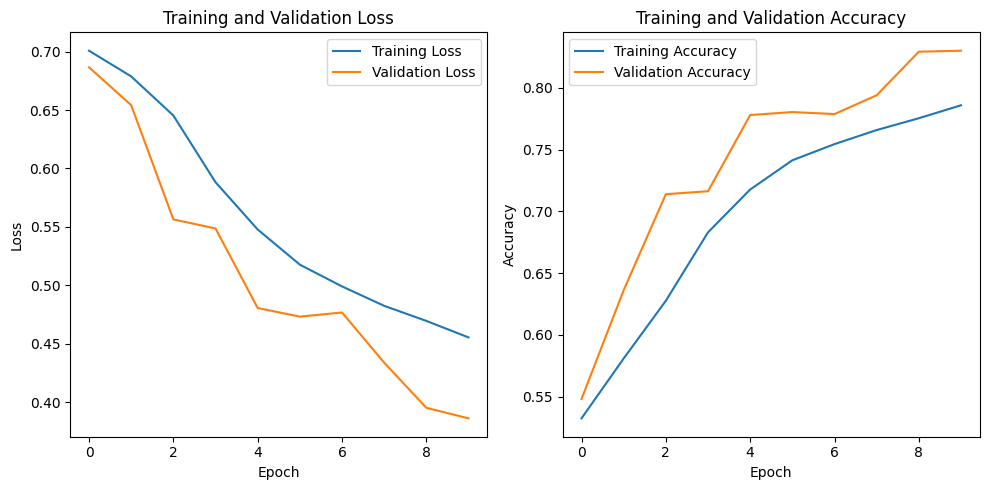

In [10]:
#Below are the plots for the loss and accuracy for both the training and validations datasets.
#Both the curves are close to each other, which shows that performs consistently and that overfitting and underfitting
#is not a problem. Unfortunately, due to limitations when it comes to the computing resources, I couldn't train the model
#for more epochs.
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# TODO: test the neural network and print the result on screen.
test_loss, test_acc = model.evaluate(test_generator)
print(f"Testing Loss: {test_loss}, Testing Accuracy: {test_acc}")


40/40 [==============================] - 3s 62ms/step - loss: 0.3636 - accuracy: 0.8384
Testing Loss: 0.3636421859264374, Testing Accuracy: 0.8384000062942505


## Saliency map implementation

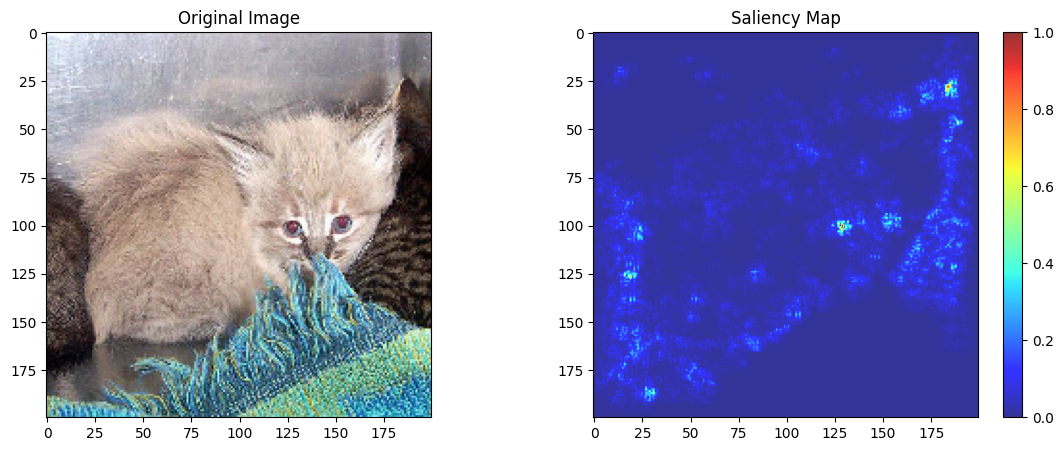

In [25]:
#In order to compute the saliency map, we first need to preprocess a random image from the testing dataset.
#Then this image is fed to the sal_map function which computes the map. First we start by getting the prediction
#using the previously trained classifier. We then check for the gradients that contributed to class choice by the model.
#This is done by using the gradient tape to record the gradients.
#We then get the maximum for the absolute value of each channel in the rgb and then we normalize it.
#This gives us the saliency map.
og_img = keras.preprocessing.image.load_img('/content/train/testing/cats/' + random.choice(os.listdir("/content/train/testing/cats")),target_size=(im_h,im_w))
img = keras.preprocessing.image.img_to_array(og_img)
img = img /255.0
img = np.expand_dims(img, axis=0)
def sal_map(image):
  image = tf.Variable(image, dtype=float)
  with tf.GradientTape() as tape:
      pred = model(image, training=False)
      score = tf.math.reduce_max(pred)
  grads = tape.gradient(score, image)
  grads_abs = tf.math.abs(grads)
  grad_max_chan = np.max(grads_abs, axis=3)[0]
  grad_eval = (grad_max_chan - np.min(grad_max_chan)) / (np.max(grad_max_chan) - np.min(grad_max_chan) + 1e-18)
  return grad_eval
eval = sal_map(img)
fig, axes = plt.subplots(1,2,figsize=(14,5))
axes[0].imshow(og_img)
ax1 = axes[1].imshow(eval,cmap="jet",alpha=0.8)
axes[0].set_title('Original Image')
axes[1].set_title('Saliency Map')
fig.colorbar(ax1)

As the dataset I have is one with images, plotting the saliency map helps with identifying the most important features in an image when it comes to predicting the class of that image. As shown on the cmap, the cat's eyes is one of the most prominent features when it comes to predicting the class that this image belongs to as it has the highest value. However, it is also evident that some features that shouldn't be affecting the prediction that much ahave a high value in the cmap.

## SmoothGrad

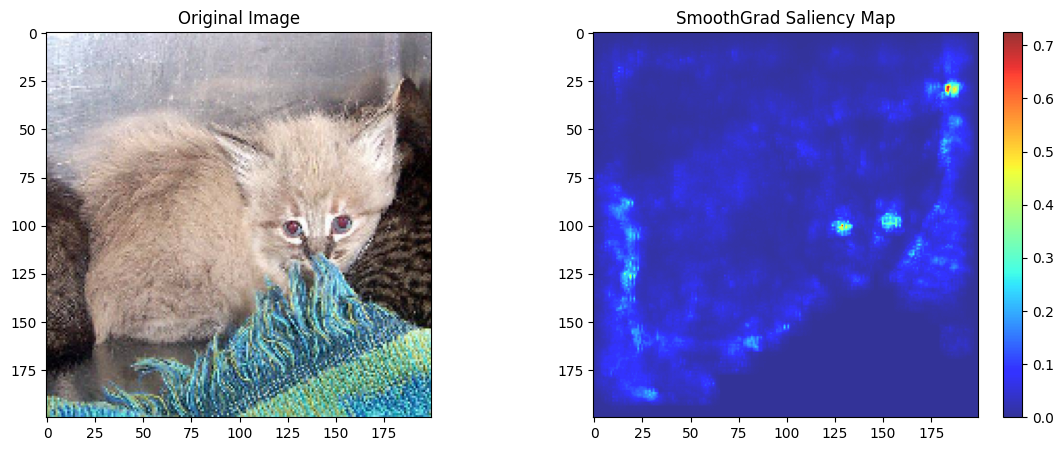

In [27]:


#First we start by generating the the noise that will be applied to the original image.
#This will be done by generating noise then adding that noise to the original image array using numpy.
#This is done multiple times using a normal distribution to generate multiple images. The function responsible for this is generate_noisy_images.
#We then calculate the saliency for each noisy image using the previously defined sal_map function and get the mean of all values
# to get the SmoothGrad saliency map

def generate_noisy_images(input_image):
    noisy_images = []
    for _ in range(50):
        noise = np.random.normal(0, 0.1, input_image.shape)
        noisy_image = input_image + noise
        noisy_images.append(noisy_image)
    return np.array(noisy_images)

noisy_inputs = generate_noisy_images(img)

gradients = []
for noisy_input in noisy_inputs:
    grad = sal_map(noisy_input)
    gradients.append(grad)
smoothgrad_map = np.mean(gradients, axis=0)



fig, axes = plt.subplots(1,2,figsize=(14,5))
ax0=axes[0].imshow(og_img)
ax1 = axes[1].imshow(smoothgrad_map,cmap="jet",alpha=0.8)
axes[0].set_title('Original Image')
axes[1].set_title('SmoothGrad Saliency Map')
fig.colorbar(ax1)

As shown in the figure above, the smoothgrad saliency map shows more features on the cats' body and they have a stronger importance here than when I displayed the vanilla saliency map. It is also evident that more pixels in the cat's eyes have a higher value than in the vanilla saliency, further indicating that the eyes are an important feature for identifying cats.

## Global saliency

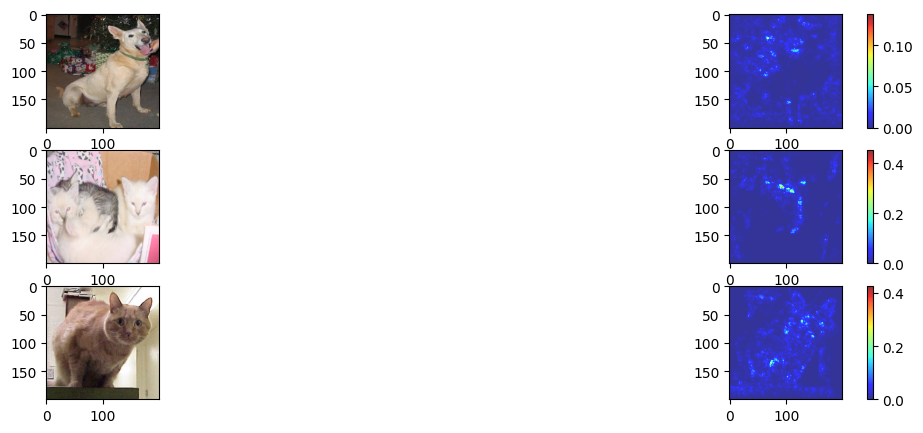

In [15]:
#the function parallel_saliency implements the same mathematical operations mentioned before,
#but on all images in a batch at once using vectorization. I also plotted 3 images of the batch as well as their maps
def parallel_saliency(image_batch,nn_model):
  image = tf.Variable(image_batch, dtype=float)
  with tf.GradientTape() as tape:
    pred = nn_model(image,training=False)
    score = tf.math.reduce_max(pred,axis=1)
  grads = tape.gradient(score, image)
  grads_abs = tf.math.abs(grads)
  grad_max_chan = np.max(grads_abs, axis=3)
  grad_eval = (grad_max_chan - np.min(grad_max_chan)) / (np.max(grad_max_chan) - np.min(grad_max_chan) + 1e-18)
  return grad_eval


images,labels = next(test_generator)
batch_sal =parallel_saliency(images,model)

fig, axes = plt.subplots(3,2,figsize=(14,5))
axes[0][0].imshow(images[0])
i_1 = axes[0][1].imshow(batch_sal[0],cmap="jet",alpha=0.8)
fig.colorbar(i_1)
axes[1][0].imshow(images[1])
i_2 = axes[1][1].imshow(batch_sal[1],cmap="jet",alpha=0.8)
fig.colorbar(i_2)
axes[2][0].imshow(images[2])
i_3 = axes[2][1].imshow(batch_sal[2],cmap="jet",alpha=0.8)
fig.colorbar(i_3)


Found 1250 images belonging to 2 classes.


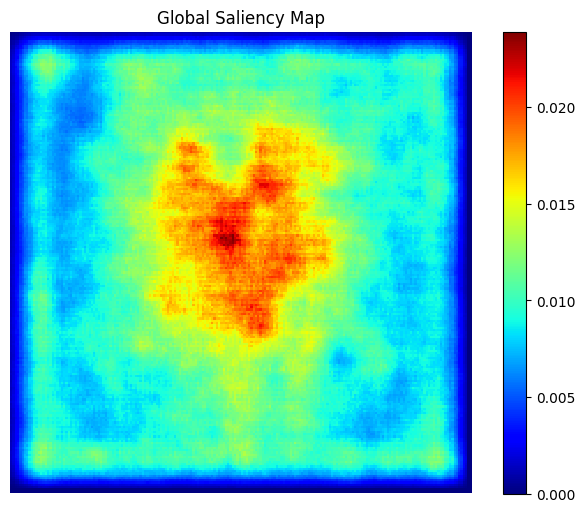

In [16]:

#the function global_saliency computes the global saliency map by feeding all of the batches to the parallel_saliency
#function and then averaging the average of each batch. And since the batches have the same number of datapoints,
#the mean of means converges to the real mean.
test_generator = testing_datagen.flow_from_directory(test_path, target_size=(im_h, im_w),
                                                batch_size=batch_size,class_mode='categorical')
def global_saliency(image_generator,nn_model,h,w):
  steps = image_generator.samples//image_generator.batch_size
  glob_sal = np.zeros((steps,h,w))
  for i in range(steps):
    images,labels = next(image_generator)
    batch_sal = parallel_saliency(images,nn_model)
    glob_sal[i] = np.mean(batch_sal,axis = 0)
  return np.mean(glob_sal, axis=0)

g_s = global_saliency(test_generator,model,200,200)
plt.figure(figsize=(8, 6))
plt.imshow(g_s, cmap='jet', interpolation='nearest')
plt.title('Global Saliency Map')
plt.colorbar()
plt.axis('off')
plt.show()

The global saliency map above shows that the center of the images are the most influential when making predictions, specifically around the facial area of the animals. This means that the model uses the faces the most to make predictions, which makes sense.

## Comparing the results with a simple linear model

In [17]:

#the linear model has 3 layers, the flattening layer to flatten the images, the dense layer, and finally the softmax
#layer to make the prediction. The model's summary is shown below.
training_datagen_linear = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)
validation_datagen_linear =ImageDataGenerator(rescale = 1./255)
testing_datagen_linear =ImageDataGenerator(rescale = 1./255)
train_generator_linear = training_datagen_linear.flow_from_directory(train_path, target_size=(64, 64),
                                                    batch_size=batch_size, class_mode='categorical')

val_generator_linear = validation_datagen_linear.flow_from_directory(valid_path, target_size=(64, 64),
                                                batch_size=batch_size,class_mode='categorical')
test_generator_linear = testing_datagen_linear.flow_from_directory(test_path, target_size=(64, 64),
                                                batch_size=batch_size,class_mode='categorical')

linear_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=((64,64,3))),
    tf.keras.layers.Dense(12288, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
linear_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
linear_model.summary()


Found 22500 images belonging to 2 classes.
Found 1250 images belonging to 2 classes.
Found 1250 images belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 12288)             0         
                                                                 
 dense_2 (Dense)             (None, 12288)             151007232 
                                                                 
 dense_3 (Dense)             (None, 2)                 24578     
                                                                 
Total params: 151031810 (576.14 MB)
Trainable params: 151031810 (576.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
history = linear_model.fit(train_generator_linear,steps_per_epoch=22500//batch_size ,epochs=10, validation_data=val_generator_linear, validation_steps=1250//batch_size)


Epoch 1/10
703/703 [==============================] - 82s 116ms/step - loss: 1.4884 - accuracy: 0.5405 - val_loss: 0.6703 - val_accuracy: 0.5713
Epoch 2/10
703/703 [==============================] - 82s 116ms/step - loss: 0.6835 - accuracy: 0.5638 - val_loss: 0.6763 - val_accuracy: 0.5665
Epoch 3/10
703/703 [==============================] - 77s 109ms/step - loss: 0.6790 - accuracy: 0.5662 - val_loss: 0.6603 - val_accuracy: 0.5938
Epoch 4/10
703/703 [==============================] - 79s 112ms/step - loss: 0.6786 - accuracy: 0.5678 - val_loss: 0.6681 - val_accuracy: 0.5913
Epoch 5/10
703/703 [==============================] - 80s 113ms/step - loss: 0.6781 - accuracy: 0.5697 - val_loss: 0.6606 - val_accuracy: 0.5970
Epoch 6/10
703/703 [==============================] - 77s 110ms/step - loss: 0.6767 - accuracy: 0.5747 - val_loss: 0.6606 - val_accuracy: 0.5954
Epoch 7/10
703/703 [==============================] - 79s 113ms/step - loss: 0.6755 - accuracy: 0.5782 - val_loss: 0.6657 - val_ac

In [19]:
#saving the model
linear_model.save('cats-dogs-linear-classifier.keras')


In [20]:
test_loss, test_acc = linear_model.evaluate(test_generator_linear)
print(f"Testing Loss: {test_loss}, Testing Accuracy: {test_acc}")

40/40 [==============================] - 2s 50ms/step - loss: 0.6508 - accuracy: 0.6144
Testing Loss: 0.6507823467254639, Testing Accuracy: 0.6144000291824341


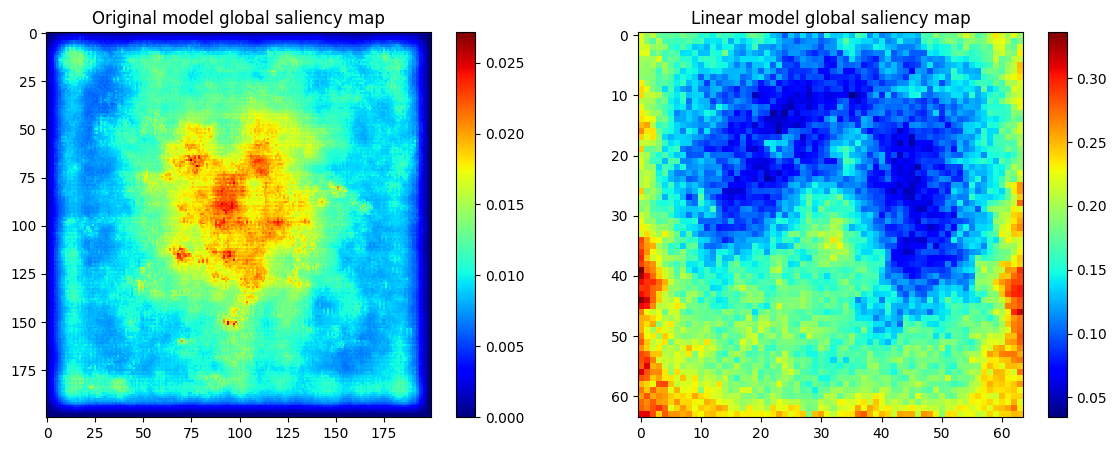

In [21]:
g_s = global_saliency(test_generator,model,200,200)
linear_g_s = global_saliency(test_generator_linear,linear_model,64,64)
fig, axes = plt.subplots(1,2,figsize=(14,5))
ax1 = axes[0].imshow(g_s, cmap='jet', interpolation='nearest')
ax2 = axes[1].imshow(linear_g_s, cmap='jet', interpolation='nearest')
axes[0].set_title('Original model global saliency map')
axes[1].set_title('Linear model global saliency map')
fig.colorbar(ax1, ax=axes[0])
fig.colorbar(ax2, ax=axes[1])


The saliency map isn't really helpful in this instant because the linear model has a very low accuracy. What causes this is the fact that the dimensions for the dataset points had to be reduced significantly for computing purposes as well as the fact that a linear model is not a good choice for a binary classification problem.

### Bibliography

[1] Simonyan, K., Vedaldi, A. and Zisserman, A., 2013. [Deep inside convolutional networks: Visualising image classification models and saliency maps](https://arxiv.org/abs/1312.6034). arXiv preprint arXiv:1312.6034.

[2] Smilkov, D., Thorat, N., Kim, B., Viégas, F. and Wattenberg, M., 2017. [SmoothGrad: removing noise by adding noise](https://arxiv.org/abs/1706.03825). arXiv preprint arXiv:1706.03825.

[3] Rudin, C., 2019. [Stop explaining black box machine learning models for high stakes decisions and use interpretable models instead](https://www.nature.com/articles/s42256-019-0048-x). Nature Machine Intelligence, 1(5), pp. 206-215.

[4] Nguyen, G., Kim, D. and Nguyen, A., 2021. [The effectiveness of feature attribution methods and its correlation with automatic evaluation scores](https://proceedings.neurips.cc/paper/2021/hash/de043a5e421240eb846da8effe472ff1-Abstract.html). Advances in Neural Information Processing Systems, 34, pp.26422-26436.

[5] Pruthi, G., Liu, F., Kale, S. and Sundararajan, M., 2020. [Estimating training data influence by tracing gradient descent](https://proceedings.neurips.cc/paper/2020/hash/e6385d39ec9394f2f3a354d9d2b88eec-Abstract.html). Advances in Neural Information Processing Systems, 33, pp. 19920-19930.